### Deep learning model training.


In [48]:
import time
import torch
import random
import torch.nn as nn
from glob import glob
from model import unet
import geopandas as gpd
from utils.imgShow import imsShow
from torchsummary import summary
from utils.utils import read_scenes
from utils.dataloader import SceneArraySet, PatchSet
from utils.acc_metric import oa_binary, miou_binary


### dataset loading

In [49]:
dir_scene = 'data/dset/scene/'
dir_dem = 'data/dset/dem/' 
dir_truth = 'data/dset/truth/' 
### secene and truth pairwise data
## traset
ids_tra_gdf = gpd.read_file('data/dset/dset_tra.gpkg')
ids_tra = ids_tra_gdf['id_scene'].tolist()
paths_scene_tra = [dir_scene+id+'_nor.tif' for id in ids_tra]
paths_dem_tra = [dir_dem+id+'_dem_nor.tif' for id in ids_tra]
paths_truth_tra = [dir_truth+id+'.tif' for id in ids_tra] 
## valset
paths_patch_valset = sorted(glob('data/dset/valset/*'))
print(f'train scenes: {len(paths_scene_tra)}, vali patch: {len(paths_patch_valset)}')


train scenes: 48, vali patch: 1959


In [50]:
scenes_arr, truths_arr = read_scenes(paths_scene_tra, 
                                     paths_truth_tra, 
                                     paths_dem_tra)

In [66]:
## Create dataset instances
tra_data = SceneArraySet(scenes_arr=scenes_arr, 
                         truths_arr=truths_arr, 
                         dems_arr=None,
                         path_size=(512, 512))
val_data = PatchSet(paths_valset=paths_patch_valset)
tra_loader = torch.utils.data.DataLoader(tra_data, 
                                         batch_size=4, 
                                         shuffle=True, 
                                         num_workers=10)
val_loader = torch.utils.data.DataLoader(val_data, 
                                         batch_size=4)

#### Model training

In [67]:
### check model
model = unet(num_bands=7)
summary(model, input_size=(7,256,256), device='cpu')


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 256, 256]           1,024
       BatchNorm2d-2         [-1, 16, 256, 256]              32
              ReLU-3         [-1, 16, 256, 256]               0
            Conv2d-4         [-1, 32, 128, 128]           4,640
       BatchNorm2d-5         [-1, 32, 128, 128]              64
              ReLU-6         [-1, 32, 128, 128]               0
            Conv2d-7           [-1, 64, 64, 64]          18,496
       BatchNorm2d-8           [-1, 64, 64, 64]             128
              ReLU-9           [-1, 64, 64, 64]               0
           Conv2d-10          [-1, 128, 32, 32]          73,856
      BatchNorm2d-11          [-1, 128, 32, 32]             256
             ReLU-12          [-1, 128, 32, 32]               0
         Upsample-13          [-1, 128, 32, 32]               0
           Conv2d-14           [-1, 64,

In [68]:
### create loss and optimizer
loss_bce = nn.BCELoss()     
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [69]:
'''------train step------'''
def train_step(model, loss_fn, optimizer, x, y):
    optimizer.zero_grad()
    pred = model(x)
    loss = loss_fn(pred, y.float())
    loss.backward()
    optimizer.step()
    miou = miou_binary(pred=pred, truth=y, device=x.device)
    oa = oa_binary(pred=pred, truth=y, device=x.device)
    return loss, miou, oa

'''------validation step------'''
def val_step(model, loss_fn, x, y):
    model.eval()
    with torch.no_grad():
        pred = model(x.float())
        loss = loss_fn(pred, y.float())
    miou = miou_binary(pred=pred, truth=y, device=x.device)
    oa = oa_binary(pred=pred, truth=y, device=x.device)
    return loss, miou, oa

'''------train loops------'''
def train_loops(model, loss_fn, optimizer, tra_loader, 
                                    val_loader, epoches, device):
    model = model.to(device)
    size_tra_loader = len(tra_loader)
    size_val_loader = len(val_loader)
    for epoch in range(epoches):
        start = time.time()
        tra_loss, val_loss = 0, 0
        tra_miou, val_miou = 0, 0
        tra_oa, val_oa = 0, 0
        '''-----train the model-----'''
        for x_batch, y_batch in tra_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            loss, miou, oa = train_step(model=model, loss_fn=loss_fn, 
                                    optimizer=optimizer, x=x_batch, y=y_batch)
            tra_loss += loss.item()
            tra_miou += miou.item()
            tra_oa += oa.item()
        '''-----validation the model-----'''
        for x_batch, y_batch in val_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            loss, miou, oa = val_step(model=model, loss_fn=loss_fn, 
                                                    x=x_batch, y=y_batch)
            val_loss += loss.item()
            val_miou += miou.item()
            val_oa += oa.item()
        ## Accuracy
        tra_loss = tra_loss/size_tra_loader
        val_loss = val_loss/size_val_loader
        tra_miou = tra_miou/size_tra_loader
        val_miou = val_miou/size_val_loader
        tra_oa = tra_oa/size_tra_loader
        val_oa = val_oa/size_val_loader
        print(f'Ep{epoch+1}: tra-> Loss:{tra_loss:.3f},Oa:{tra_oa:.2f},Miou:{tra_miou:.2f}, '
              f'val-> Loss:{val_loss:.2f},Oa:{val_oa:.2f},Miou:{val_miou:.2f},time:{time.time()-start:.0f}s')
        ## show the result
        if (epoch+1)%10 == 0:
            model.eval()
            sam_index = random.randrange(len(val_data))
            patch, truth = val_data[sam_index]
            patch, truth = torch.unsqueeze(patch.float(), 0).to(device), truth.to(device)
            pred = model(patch)
            ## convert to numpy and plot
            patch = patch[0].to('cpu').detach().numpy().transpose(1,2,0)
            pred = pred[0].to('cpu').detach().numpy()
            truth = truth.to('cpu').detach().numpy()
            imsShow([patch, truth, pred], 
                    img_name_list=['input_patch', 'truth', 'prediction'] , figsize=(10,4))


Ep1: tra-> Loss:0.441,Oa:0.79,Miou:0.71, val-> Loss:0.53,Oa:0.56,Miou:0.43,time:4s
Ep2: tra-> Loss:0.261,Oa:0.90,Miou:0.74, val-> Loss:0.25,Oa:0.80,Miou:0.72,time:4s
Ep3: tra-> Loss:0.359,Oa:0.90,Miou:0.83, val-> Loss:0.20,Oa:0.81,Miou:0.73,time:4s
Ep4: tra-> Loss:0.179,Oa:0.95,Miou:0.83, val-> Loss:0.18,Oa:0.82,Miou:0.73,time:4s
Ep5: tra-> Loss:0.105,Oa:0.92,Miou:0.86, val-> Loss:0.15,Oa:0.82,Miou:0.74,time:4s
Ep6: tra-> Loss:0.144,Oa:0.95,Miou:0.91, val-> Loss:0.14,Oa:0.82,Miou:0.75,time:4s
Ep7: tra-> Loss:0.102,Oa:0.93,Miou:0.89, val-> Loss:0.14,Oa:0.83,Miou:0.75,time:4s
Ep8: tra-> Loss:0.111,Oa:0.95,Miou:0.90, val-> Loss:0.13,Oa:0.83,Miou:0.75,time:4s
Ep9: tra-> Loss:0.114,Oa:0.87,Miou:0.83, val-> Loss:0.15,Oa:0.83,Miou:0.75,time:4s
Ep10: tra-> Loss:0.112,Oa:0.96,Miou:0.91, val-> Loss:0.13,Oa:0.83,Miou:0.76,time:4s


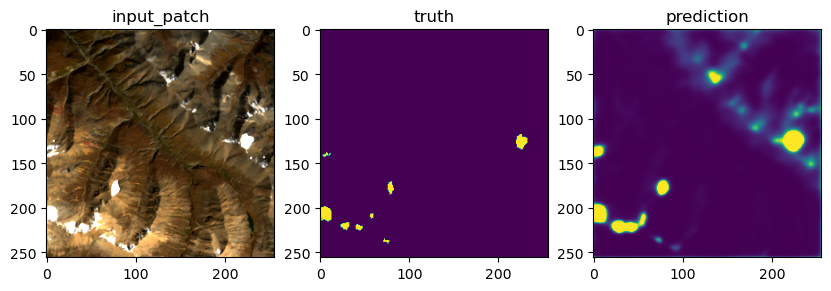

Ep11: tra-> Loss:0.078,Oa:0.94,Miou:0.89, val-> Loss:0.15,Oa:0.83,Miou:0.76,time:4s
Ep12: tra-> Loss:0.137,Oa:0.93,Miou:0.89, val-> Loss:0.13,Oa:0.84,Miou:0.76,time:4s
Ep13: tra-> Loss:0.095,Oa:0.92,Miou:0.88, val-> Loss:0.12,Oa:0.84,Miou:0.76,time:4s
Ep14: tra-> Loss:0.076,Oa:0.95,Miou:0.91, val-> Loss:0.13,Oa:0.84,Miou:0.77,time:4s
Ep15: tra-> Loss:0.128,Oa:0.93,Miou:0.88, val-> Loss:0.14,Oa:0.84,Miou:0.76,time:4s
Ep16: tra-> Loss:0.078,Oa:0.91,Miou:0.86, val-> Loss:0.13,Oa:0.84,Miou:0.76,time:4s
Ep17: tra-> Loss:0.120,Oa:0.95,Miou:0.90, val-> Loss:0.12,Oa:0.84,Miou:0.77,time:4s
Ep18: tra-> Loss:0.100,Oa:0.95,Miou:0.91, val-> Loss:0.12,Oa:0.84,Miou:0.76,time:4s
Ep19: tra-> Loss:0.089,Oa:0.94,Miou:0.91, val-> Loss:0.12,Oa:0.84,Miou:0.77,time:4s
Ep20: tra-> Loss:0.078,Oa:0.96,Miou:0.93, val-> Loss:0.13,Oa:0.84,Miou:0.76,time:4s


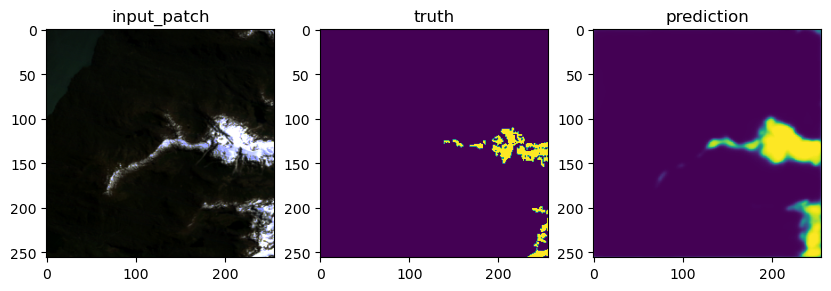

In [70]:
# device = torch.device('cpu') 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_loops(model=model, 
            epoches=20,  
            loss_fn=loss_bce, 
            optimizer=optimizer, 
            tra_loader=tra_loader,  
            val_loader=val_loader,  
            device=device)     


In [71]:
# # model saving
# path_save = 'model/trained/unet_l5789_s2.pth'
# torch.save(model.state_dict(), path_save)   # save weights of the trained model 
# model.load_state_dict(torch.load(path_save, weights_only=True))  # load the weights of the trained model
